## Learning time intervals with UTC

Here, we will apply the one-shot learning rule for time production proposed by Simen et al. (2011) and Rivest & Bengio (2011). 

In [1]:
import nengo
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry
import numpy as np
import os
import sys

import pylab
%pylab inline

import pandas as pd
import seaborn as sns
import itertools
import scipy
import string
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.ensemble import response_curves, tuning_curves

import os
import sys

Populating the interactive namespace from numpy and matplotlib


/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# UTC_prospective contains main functions for simulating the UTC model
%run ./UTC_prospective.py

In [3]:
plt.rcParams['lines.marker'] = ''
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3


In [4]:
def learning_rule(rate, z, x, y, r, alpha=1, timestep=0.001):
    # The learning rule can be divided into a late-timer and early-timer part
    
    # The late timer increases rate on the next trial when the timer is too late
    # y * rate * ((z-x) / x), 
    # where y is a dirac delta function at the end of the interval
    # z is the threshold, and x is the time readout
    late_timer = y * rate * ((z-x) / x)
    
    # The early timer decreases rate on the next trial when the timer is too early
    # - (rate**2 / z) * r
    # where r is 1 from crossing the threshold until the end of the interval, 0 elsewhere
    early_timer = rate**2 * r * timestep
    
    # Now combine them in one formula
    d_rate = late_timer - early_timer
    
    return rate + d_rate*alpha

### Apply learning rule to UTC

In [5]:
# set target intervals
unique_intervals = [10, 2, 5]
n_repeats = 30
target_intervals = np.concatenate([
    np.repeat(unique_intervals[0], n_repeats),
    np.repeat(unique_intervals[1], n_repeats),
    np.repeat(unique_intervals[2], n_repeats)])

theta = 10

mypath = 'learning_test'
if not os.path.isdir(mypath):
    os.makedirs(mypath)

In [6]:
%%capture

m = 3
for i in range(0, len(target_intervals)):
    target_interval = target_intervals[i]
    UTC_prospective().run(task_type='prospective_motor',
                                     dimensions=1,
                                     prestim=0.,
                                     verbose=False,
                                     effective_theta=theta,
                                     full_output=True,
                                     seed=i,
                                     between_gain_noise_std=0.,
                                     input_noise_std = m * np.sqrt(theta), # for constant CV
                                     within_gain_noise_std=0.,
                                     data_dir='learning_test/trial{}'.format(i),
                                     ID = i)

    # Read in data
    learning_data = pytry.read('learning_test/trial{}'.format(i))
    learning_dt = pd.DataFrame(learning_data)
    #learning_dt = learning_dt[(learning_dt['ID']==i)]

    # Get parameters
    theta = learning_dt['effective_theta'].to_numpy()[0]
    threshold = learning_dt['threshold'].values[0]

    # Get data
    x = learning_dt['state'].values[0][:,0]
    t = np.arange(0, len(x), 1) / 1000 # in seconds

    # when x crosses the threshold, r=1 until the end of the interval
    r = np.zeros(x.shape[0])
    r[np.where(x.squeeze() > threshold)[0][0]:target_interval*1000] = 1

    # y is 1 at the end of the interval, only when there's not responding yet
    y = np.zeros(x.shape[0])
    if learning_dt['rt'].to_numpy()[0] > target_interval*1000:
        y[t == target_interval] = 1

    rate = 1/theta
    rate_trace = []
    for i in range(x.shape[0]-2):
        if x[i] > 0:
            rate = learning_rule(rate, threshold,
                                 x[i], y[i], r[i+2], alpha=1)

        rate_trace.append(rate)

    # get final rate, and use for next theta
    theta = 1/rate_trace[-1]


In [6]:
import os
import shutil

folder = r"learning_test"
subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]

for sub in subfolders:
    for f in os.listdir(sub):
        src = os.path.join(sub, f)
        dst = os.path.join(folder, f)
        shutil.move(src, dst)

In [7]:
# Read in data
learning_data = pytry.read('learning_test')
learning_dt = pd.DataFrame(learning_data)

In [8]:
learning_dt = learning_dt.sort_values(by=['ID'])
learning_dt['target_interval'] = target_intervals

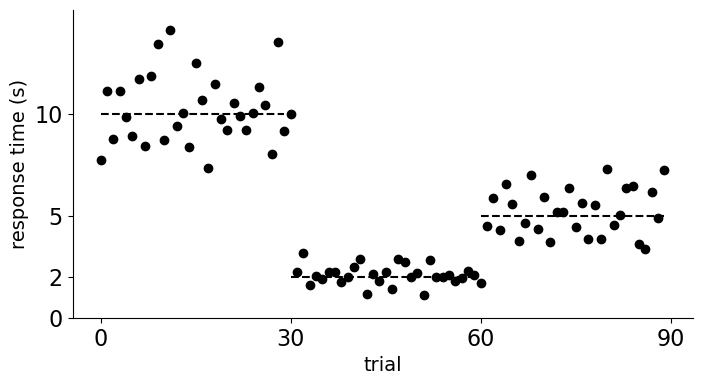

In [9]:
fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=1)

trials = learning_dt['ID'].to_numpy()
xmins = np.array([
    trials[np.where(target_intervals==unique_intervals[0])][0],
    trials[np.where(target_intervals==unique_intervals[1])][0],
    trials[np.where(target_intervals==unique_intervals[2])][0]])

xmaxs = np.array([
    trials[np.where(target_intervals==unique_intervals[0])][-1],
    trials[np.where(target_intervals==unique_intervals[1])][-1],
    trials[np.where(target_intervals==unique_intervals[2])][-1]])

axes.scatter(trials, learning_dt['rt']/1000, marker='o', color='black')
#plt.scatter(trials, learning_dt['effective_theta'], marker='o', color='red', alpha=0.2)
axes.hlines(y=unique_intervals, xmin=xmins, xmax=xmaxs,
           ls='dashed', color='black')

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

axes.set_xlabel('trial')
axes.set_ylabel('response time (s)')

axes.set_xticks(np.arange(0, len(target_intervals) + 1, n_repeats))
axes.set_yticks(np.concatenate([[0], unique_intervals]))

axes.set_ylim([0, np.max(learning_dt['rt']/1000) + 1])

fig.savefig('UTC_learning_example.png', dpi=400, bbox_inches='tight')

## Demonstrating the early and late timing rule

### Late timing rule

In [85]:
# Read in data
late_rule_dt = learning_dt[(learning_dt['ID']==30)]

# Get parameters
theta = late_rule_dt['effective_theta'].to_numpy()[0]
threshold = late_rule_dt['threshold'].values[0]
target_interval = target_intervals[30]

# Get data
x = late_rule_dt['state'].values[0][:,0]
t = np.arange(0, len(x), 1) / 1000 # in seconds

# when x crosses the threshold, r=1 until the end of the interval
r = np.zeros(x.shape[0])
r[(x.squeeze() > threshold) & (t < target_interval)] = 1

# y is 1 at the end of the interval, only when there's not responding yet
y = np.zeros(x.shape[0])
if late_rule_dt['rt'].to_numpy()[0] > target_interval*1000:
    y[t == target_interval] = 1

rate = 1/theta
rate_trace = []
for i in range(x.shape[0]-2):
    if x[i] > 0:
        rate = learning_rule(rate, threshold,
                             x[i], y[i], r[i+2], alpha=1)

    rate_trace.append(rate)

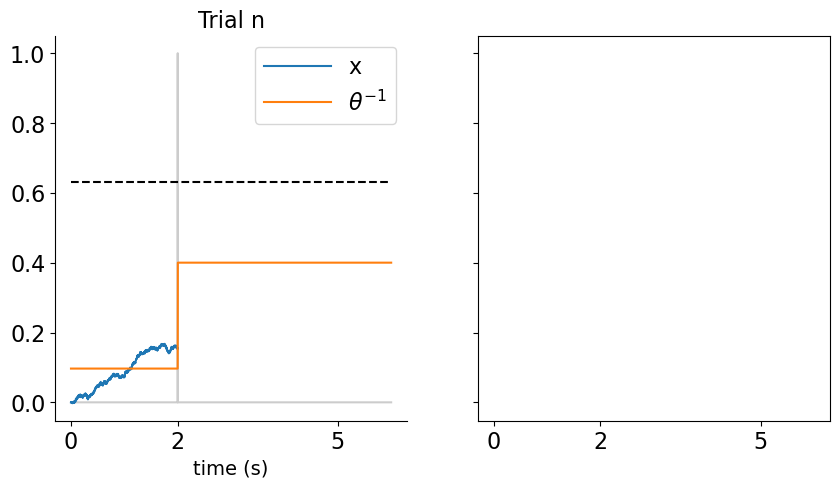

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

axes[0].plot(t[0:2000], x[0:2000], label='x')
axes[0].plot(t[0:6000], rate_trace[0:6000], label=r'$\theta^{-1}$')
axes[0].plot(t[0:6000], y[0:6000], color='black', zorder=0, alpha=0.2)

axes[0].hlines(y=threshold, xmin=0, xmax=6, ls='dashed', color='black')
axes[0].set_xticks([0, 2, 5])
axes[0].set_xlabel('time (s)')
axes[0].set_title('Trial n')

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

legend = axes[0].legend(loc='upper right', title='', fontsize=16)

In [87]:
# Read in data
late_rule_dt = learning_dt[(learning_dt['ID']==31)]

# Get parameters
theta = late_rule_dt['effective_theta'].to_numpy()[0]
threshold = late_rule_dt['threshold'].values[0]
target_interval = target_intervals[30]

# Get data
x = late_rule_dt['state'].values[0][:,0]
t = np.arange(0, len(x), 1) / 1000 # in seconds

# when x crosses the threshold, r=1 until the end of the interval
r = np.zeros(x.shape[0])
r[(x.squeeze() > threshold) & (t < target_interval)] = 1

# y is 1 at the end of the interval, only when there's not responding yet
y = np.zeros(x.shape[0])
if late_rule_dt['rt'].to_numpy()[0] > target_interval*1000:
    y[t == target_interval] = 1

rate = 1/theta
rate_trace = []
for i in range(x.shape[0]-2):
    if x[i] > 0:
        rate = learning_rule(rate, threshold,
                             x[i], y[i], r[i+2], alpha=1)

    rate_trace.append(rate)

In [88]:
axes[1].plot(t[0:2000], x[0:2000])
axes[1].plot(t[0:6000], rate_trace[0:6000])
axes[1].plot(t[0:6000], y[0:6000], color='black', zorder=0, alpha=0.2)

axes[1].hlines(y=threshold, xmin=0, xmax=6, ls='dashed', color='black')
axes[1].set_xticks([0, 2, 5])
axes[1].set_xlabel('time (s)')
axes[1].set_title('Trial n+1')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

fig.suptitle('Late timing rule')

Text(0.5, 0.98, 'Late timing rule')

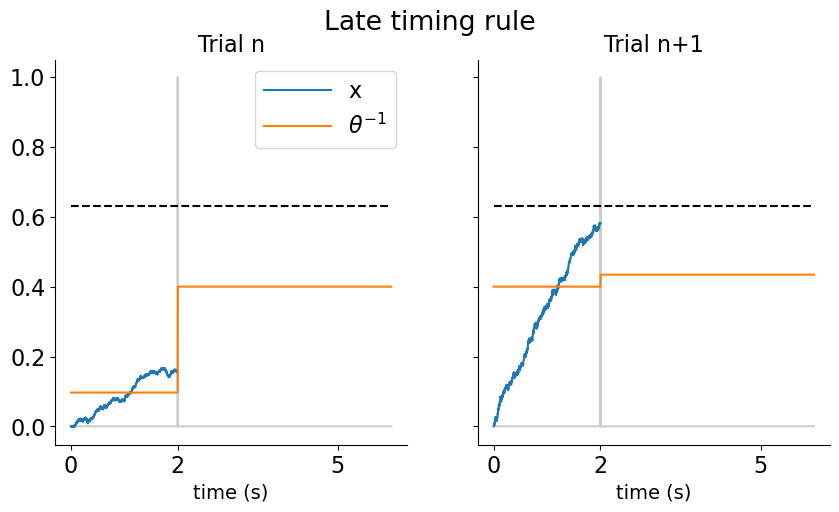

In [89]:
fig

In [90]:
fig.savefig('late_timing_rule.png', dpi=800)

### Early timing rule

In [91]:
# Read in data
early_rule_dt = learning_dt[(learning_dt['ID']==60)]

# Get parameters
theta = early_rule_dt['effective_theta'].to_numpy()[0]
threshold = early_rule_dt['threshold'].values[0]
target_interval = target_intervals[60]

# Get data
x = early_rule_dt['state'].values[0][:,0]
t = np.arange(0, len(x), 1) / 1000 # in seconds

# when x crosses the threshold, r=1 until the end of the interval
r = np.zeros(x.shape[0])
r[np.where(x.squeeze() > threshold)[0][0]:target_interval*1000] = 1

# y is 1 at the end of the interval, only when there's not responding yet
y = np.zeros(x.shape[0])
if late_rule_dt['rt'].to_numpy()[0] > target_interval*1000:
    y[t == target_interval] = 1

rate = 1/theta
rate_trace = []
for i in range(x.shape[0]-2):
    if x[i] > 0:
        rate = learning_rule(rate, threshold,
                             x[i], y[i], r[i+2], alpha=1)

    rate_trace.append(rate)

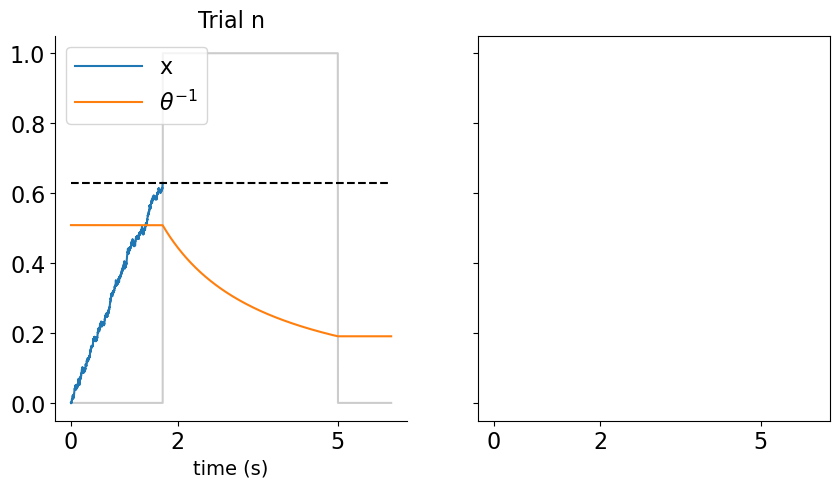

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

axes[0].plot(t[0:np.where(x.squeeze() > threshold)[0][0]], 
             x[0:np.where(x.squeeze() > threshold)[0][0]], label='x')
axes[0].plot(t[0:6000], rate_trace[0:6000], label=r'$\theta^{-1}$')
axes[0].plot(t[0:6000], r[0:6000], color='black', zorder=0, alpha=0.2)

axes[0].hlines(y=threshold, xmin=0, xmax=6, ls='dashed', color='black')
axes[0].set_xticks([0, 2, 5])
axes[0].set_xlabel('time (s)')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

axes[0].set_title('Trial n')

legend = axes[0].legend(loc='upper left', title='', fontsize=16)

In [93]:
# Read in data
early_rule_dt = learning_dt[(learning_dt['ID']==61)]

# Get parameters
theta = early_rule_dt['effective_theta'].to_numpy()[0]
threshold = early_rule_dt['threshold'].values[0]
target_interval = target_intervals[61]

# Get data
x = early_rule_dt['state'].values[0][:,0]
t = np.arange(0, len(x), 1) / 1000 # in seconds

# when x crosses the threshold, r=1 until the end of the interval
r = np.zeros(x.shape[0])
r[np.where(x.squeeze() > threshold)[0][0]:target_interval*1000] = 1

# y is 1 at the end of the interval, only when there's not responding yet
y = np.zeros(x.shape[0])
if late_rule_dt['rt'].to_numpy()[0] > target_interval*1000:
    y[t == target_interval] = 1

rate = 1/theta
rate_trace = []
for i in range(x.shape[0]-2):
    if x[i] > 0:
        rate = learning_rule(rate, threshold,
                             x[i], y[i], r[i+2], alpha=1)

    rate_trace.append(rate)

In [94]:
axes[1].plot(t[0:np.where(x.squeeze() > threshold)[0][0]], 
             x[0:np.where(x.squeeze() > threshold)[0][0]], label='x')
axes[1].plot(t[0:6000], rate_trace[0:6000])
axes[1].plot(t[0:6000], r[0:6000], color='black', zorder=0, alpha=0.2)
axes[1].set_xlabel('time (s)')

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_title('Trial n+1')
axes[1].hlines(y=threshold, xmin=0, xmax=6, ls='dashed', color='black')
axes[1].set_xticks([0, 2, 5])

fig.suptitle('Early timing rule')

Text(0.5, 0.98, 'Early timing rule')

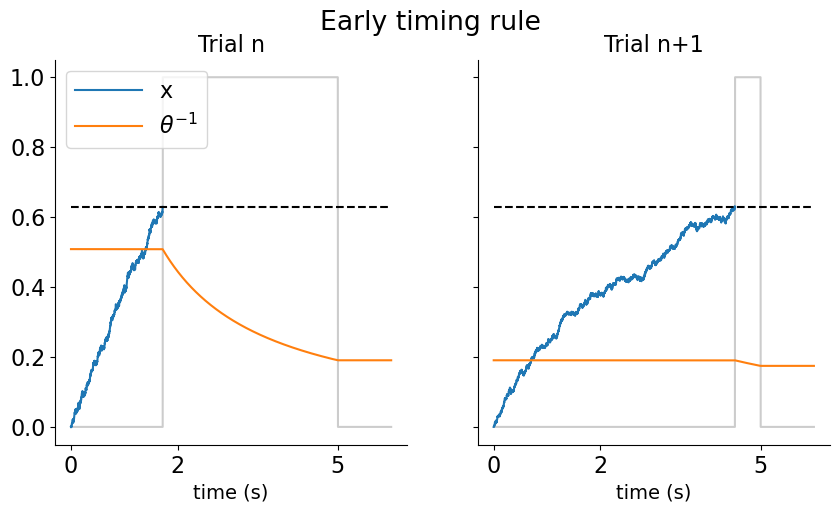

In [95]:
fig

In [96]:
fig.savefig('early_timing_rule.png', dpi=800)